# import library & Package


In [1]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 27.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successful

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import cv2
import shutil
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import ImageEnhance, Image
from collections import Counter
from tqdm import tqdm
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflowjs as tfjs

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#import library & Package


In [4]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/dataset_bunga.zip'

!unzip -q "/content/drive/MyDrive/dataset_bunga.zip" -d "/content/"

Mounted at /content/drive


# Pra-Pemrosesan Data Gambar

## Resolusi Data Gambar

In [5]:
dataset_path = '/content/flower_images'
resolutions = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                resolutions.append(img.size)
            except:
                continue

#hitung & menampilkan ukuran yang paling umum
res_counter = Counter(resolutions)
print("Top 10 resolusi gambar yang ditemukan:")
print(res_counter.most_common(10))

#total variasi resolusi
print(f"\nTotal variasi resolusi unik: {len(set(resolutions))}")

Top 10 resolusi gambar yang ditemukan:
[((275, 183), 573), ((225, 225), 375), ((300, 168), 189), ((183, 275), 152), ((284, 177), 144), ((259, 194), 125), ((168, 300), 64), ((276, 183), 58), ((194, 259), 55), ((612, 408), 55)]

Total variasi resolusi unik: 1380


**Insight:**
* dataset memiliki 1380 variasi resolusi unik, menunjukkan ukuran gambar sangat bervariasi.
* resolusi paling umum: (275, 183) dan (225, 225).
* Gambar terdiri dari landscape & portrait, sehingga preprocessing resize ke 180x180 sudah tepat untuk menyamakan input dan menjaga konsistensi model.





## splitting data

In [6]:
!pip install split-folders tqdm
import splitfolders

dataset_path = '/content/flower_images'
output_path = '/content/flower_images_split'

#split dataset
splitfolders.ratio(dataset_path, output=output_path, seed=1337, ratio=(.8, .1, .1))

Copying files: 5000 files [00:00, 5406.38 files/s]


**Insight:**
dataset telah berhasil dibagi menggunakan `splitfolders` dengan rasio **80%** untuk train, **10%** untuk validation, dan **10%** untuk test. Dari total 5000 gambar, sekitar 4000 gambar digunakan untuk pelatihan, 500 untuk validasi, dan 500 untuk pengujian. Struktur folder hasil split tersimpan di `/content/flower_images_split` dengan subfolder per kelas pada masing-masing set.


## Data Cleaning

In [7]:
#untuk mengecek apakah gambar buram
def is_blurry(image_path, threshold=100):
    image = cv2.imread(image_path)
    if image is None:
        return True
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance < threshold

#pembersihan gambar dalam folder
def clean_directory(dir_path, threshold=100):
    deleted_count = 0
    for class_folder in os.listdir(dir_path):
        class_path = os.path.join(dir_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                if is_blurry(img_path, threshold):
                    os.remove(img_path)
                    deleted_count += 1
                    print(f"Deleted blurry image: {img_path}")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    print(f"Total blurry images deleted from {dir_path}: {deleted_count}")

#jalankan untuk masing-masing direktori
clean_directory('/content/flower_images_split/train')
clean_directory('/content/flower_images_split/val')
clean_directory('/content/flower_images_split/test')


Deleted blurry image: /content/flower_images_split/train/Lilly/871fa68fdd.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/301b28fabe.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/83657b8b10.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/f26356adc0.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/5fe46517e0.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/f90a1fbcb7.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/d18735dfb4.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/4739f59723.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/52236b1a56.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/80bbf7b08d.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/844d7f05b0.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/53815c5e4d.jpg
Deleted blurry image: /content/flower_images_split/train/Lilly/7

**Insight:**
gambar blur telah dihapus dari dataset menggunakan deteksi blur berbasis Laplacian.
* gambar blur yg di delete di train : `379`
* gambar blur yg di delete di val: `47`
* gambar blur yg di delete di test: `48`


# normalisasi & rekap jumlah gambar per dataset

In [9]:
train_dir = "/content/flower_images_split/train"
val_dir   = "/content/flower_images_split/val"
test_dir  = "/content/flower_images_split/test"

img_size = (180, 180)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Updated paths for train_dir, val_dir, and test_dir
train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen   = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen  = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Cek jumlah gambar
print("Total gambar di TRAIN SET:", train_gen.samples)
print("Total gambar di VALIDATION SET:", val_gen.samples)
print("Total gambar di TEST SET:", test_gen.samples)
print("Total keseluruhan:", train_gen.samples + val_gen.samples + test_gen.samples)

Found 3621 images belonging to 5 classes.
Found 453 images belonging to 5 classes.
Found 452 images belonging to 5 classes.
Total gambar di TRAIN SET: 3621
Total gambar di VALIDATION SET: 453
Total gambar di TEST SET: 452
Total keseluruhan: 4526


# arsitektur CNN

In [31]:
# Membuat model baru
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(180,180,3))) # Change input shape to (180, 180, 3)
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 4
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk mencegah overfitting
model.add(Dense(5, activation='softmax'))  # 5 kelas

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 11, 11, 256)         │              

 Total params: 8,516,389 (32.49 MB)

 Trainable params: 8,514,981 (32.48 MB)

 Non-trainable params: 1,408 (5.50 KB)

# training model & callback

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9717 - loss: 0.0897

114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.9716 - loss: 0.0900 - val_accuracy: 0.8190 - val_loss: 0.7418
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.9362 - loss: 0.1726 - val_accuracy: 0.8146 - val_loss: 0.7580
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.9518 - loss: 0.1423 - val_accuracy: 0.7969 - val_loss: 0.7327
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9656 - loss: 0.1090

114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9656 - loss: 0.1092 - val_accuracy: 0.8344 - val_loss: 0.5906
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9632 - loss: 0.1003 - val_accuracy: 0.8300 - val_loss: 0.5935
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9682 - loss: 0.0844 - val_accuracy: 0.8079 - val_loss: 0.7493
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.9758 - loss: 0.0866 - val_accuracy: 0.8278 - val_loss: 0.6880
Epoch 8/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9815 - loss: 0.0532

114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9815 - loss: 0.0533 - val_accuracy: 0.8433 - val_loss: 0.5972
Epoch 9/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9861 - loss: 0.0445

114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9860 - loss: 0.0446 - val_accuracy: 0.8565 - val_loss: 0.6805
Epoch 10/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9876 - loss: 0.0408 - val_accuracy: 0.8322 - val_loss: 0.7103
Epoch 11/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.9753 - loss: 0.0821 - val_accuracy: 0.8433 - val_loss: 0.6939
Epoch 12/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.9844 - loss: 0.0511 - val_accuracy: 0.8565 - val_loss: 0.6737
Epoch 13/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.9825 - loss: 0.0550 - val_accuracy: 0.8543 - val_loss: 0.6920
Epoch 14/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9846 - loss: 0.0506

114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.9846 - loss: 0.0506 - val_accuracy: 0.8631 - val_loss: 0.8300


# evaluasi model

In [36]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Training Accuracy: 98.56%
Final Validation Accuracy: 86.31%


In [37]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8455 - loss: 0.5940
Test Accuracy: 85.62%


# visualisasi akurasi & loss

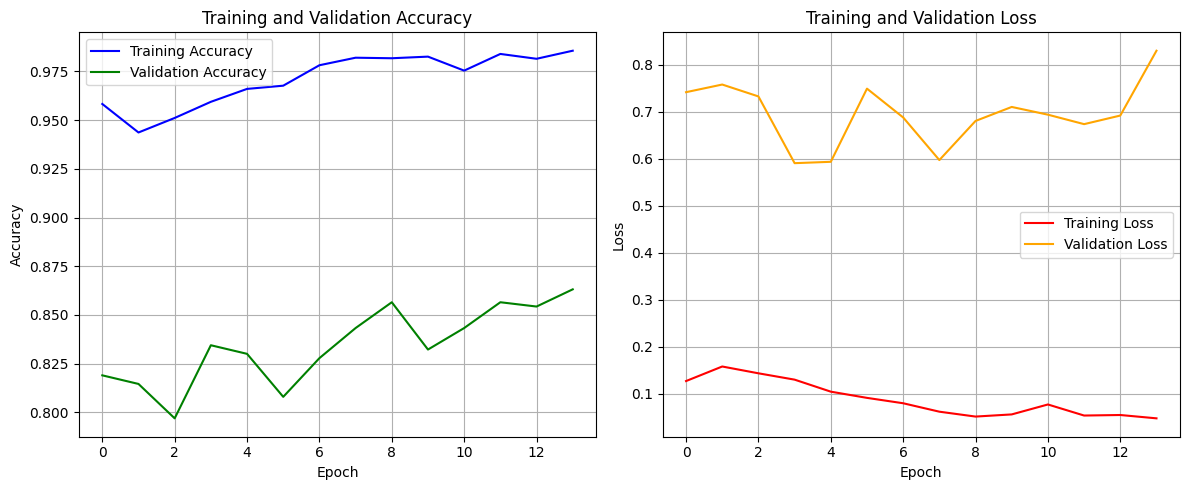

In [39]:
# Visualisasi Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Visualisasi Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Insight:**
* Training accuracy dan validation accuracy naik stabil ➔ model belajar dengan baik.
* Training loss turun konsisten, validation loss stabil ➔ belum ada overfitting serius.
* Ada sedikit fluktuasi di validation loss, wajar, tapi perlu diawasi jika training lebih lama.
* Training 30 epoch cukup optimal. Training terlalu lama (50+ epoch) berisiko overfitting.

# simpan model dalam berbagai format

## SavedModel

In [40]:
#update filename to 'best_model.keras'
model = tf.keras.models.load_model("best_model.keras")

#export ke format SavedModel
model.export("saved_model")

print("✅ Model berhasil diekspor ke SavedModel (.pb format)")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134733229158864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229157136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229159824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229161552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229162128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229159632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733256917648: Ten

## TensorFlow-Lite (TF-Lite)

In [41]:
#mengonversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#menyimpan model TF-Lite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model telah disimpan dalam format TensorFlow Lite (TF-Lite).")

Saved artifact at '/tmp/tmph3dhxmmk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134733229158864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229157136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229159824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229161552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229162128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229160208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733229159632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134733256917648

## TensorFlow-JS (TF-JS)

In [42]:
#menyimpan model dalam format TensorFlow.js
tfjs.converters.save_keras_model(model, 'model_tfjs')

print("Model telah disimpan dalam format TensorFlow.js (TFJS).")

failed to lookup keras version from the file,
    this is likely a weight only file
Model telah disimpan dalam format TensorFlow.js (TFJS).


# inference

## SavedModel

In [43]:
# Load the SavedModel as an inference-only layer
model_saved = tf.keras.layers.TFSMLayer('saved_model', call_endpoint='serving_default')

# Generate input data with the correct shape (1, 180, 180, 3)
# assuming your model expects images of size 180x180 with 3 color channels
input_data = tf.random.normal([1, 180, 180, 3])

# Perform inference
infer_result = model_saved(input_data)

# Print the inference result
print("Inference result (SavedModel):", infer_result)

Inference result (SavedModel): {'output_0': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[1.7250634e-14, 3.0660804e-14, 1.2864562e-09, 1.0000000e+00,
        2.8202826e-14]], dtype=float32)>}


## TensorFlow-Lite (TF-Lite)

In [44]:
#memuat model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

#menyediakan input data dan mempersiapkan inferensi
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_data = np.random.random(input_details[0]['shape']).astype(np.float32)

#menyediakan input untuk interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)

#melakukan inferensi
interpreter.invoke()

#mengambil hasil inferensi
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Hasil inferensi (TensorFlow Lite):", output_data)

Hasil inferensi (TensorFlow Lite): [[1.1156857e-03 1.2411011e-04 1.7968507e-03 9.9685633e-01 1.0702296e-04]]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
